# Survival analysis

The following function provides both Cox  proprotional hazards modelling and Kaplan-Meier plots.

In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
from mlrun.mlutils import (get_sample, get_splits, gen_sklearn_model,
                     create_class, eval_model_v2, gcf_clear)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact, TableArtifact

from cloudpickle import dumps
import pandas as pd
import os

from lifelines import CoxPHFitter, KaplanMeierFitter

## train

In [4]:
def _coxph_log_model(
    context,
    model, 
    dataset_key: str  = "coxhazard-summary",
    models_dest: str = "models",
    plot_cov_groups: bool = False,
    p_value: float = 0.005,
    plot_key: str  = "km-cx",
    plots_dest: str = "plots",
    file_ext="csv",
    extra_data: dict = {}
):
    """log a coxph model (and submodel locations)
    
    :param model:        estimated coxph model
    :param extra_data:   if this model wants to store the locations of submodels
                         use this
    """
    import matplotlib.pyplot as plt
    
    sumtbl = model.summary
    
    context.log_dataset(dataset_key, df=sumtbl,
                        index=True, format=file_ext)

    model_bin = dumps(model)
    context.log_model("cx-model", body=model_bin, 
                      artifact_path=os.path.join(context.artifact_path, models_dest),
                      # model_dir=models_dest, 
                      model_file="model.pkl")
    # this will look at regression estimate stats and select, based on p_values,
    # only those covariates of interest and display a plot for each vs all
    # stratification group combos (~15 charts per stratification variable => 60 charts)
    if plot_cov_groups:
        select_covars = summary[summary.p<=p_value].index.values
        for group in select_covars:
            axs = model.plot_covariate_groups(group, values=[0, 1])
            for ix, ax in enumerate(axs):
                f = ax.get_figure()
                context.log_artifact(
                    PlotArtifact(f"cx-{group}-{ix}", body=plt.gcf()), 
                    local_path=f"{plots_dest}/cx-{group}-{ix}.html")
                gcf_clear(plt)

In [5]:
def _kaplan_meier_log_model(
    context,
    model, 
    time_column: str = "tenure",
    dataset_key: str  = "km-timelines",
    plot_key: str  = "km-survival",
    plots_dest: str = "plots",
    models_dest: str = "models",
    file_ext: str = "csv"
):
    import matplotlib.pyplot as plt
    o = []
    for obj in model.__dict__.keys():
        if isinstance(model.__dict__[obj], pd.DataFrame):
            o.append(model.__dict__[obj])
    df = pd.concat(o, axis=1)
    df.index.name = time_column
    context.log_dataset(dataset_key, df=df, index=True, format=file_ext)
    # plot the model and grab figure
    model.plot()
    context.log_artifact(PlotArtifact(plot_key, body=plt.gcf()), 
                         local_path=f"{plots_dest}/{plot_key}.html")
    # log model
    context.log_model("km-model", 
                      body=dumps(model), 
                      model_dir=f"{models_dest}/km", 
                      model_file="model.pkl")

In [6]:
def train_model(
    context: MLClientCtx,
    dataset: DataItem,
    event_column: str = "labels",
    time_column: str = "tenure",
    encode_cols: dict = {},
    strata_cols: list = [],
    plot_cov_groups: bool = False,
    p_value: float = 0.005,
    sample: int = -1,
    test_size: float = 0.25,
    valid_size: float = 0.75, # (after test removed)
    random_state: int = 1,
    models_dest: str = "",
    plots_dest: str = "",
    file_ext: str = "csv",
) -> None:
    """train models to predict the timing of events
    
    Although identical in structure to other training functions, this one
    requires generating a 'Y' that represents the age/duration/tenure of
    the obervation, designated 'tenure' here, and a binary labels columns that
    represents the event of interest, churned/not-churned.
    
    In addition, there is a strata_cols parameter, representing a list of 
    stratification (aka grouping) variables.
    
    :param context:           the function context
    :param dataset:           ("data") name of raw data file
    :param event_column:      ground-truth (y) labels (considered as events in this model)
    :param time_column:       age or tenure column
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param strata_cols:       columns used to stratify predictors
    :param plot_cov_groups:   
    :param p_value:           (0.005) max p value for coeffcients selected
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param test_size:         (0.25) test set size
    :param valid_size:        (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       destination subfolder for model artifacts
    :param plots_dest:        destination subfolder for plot artifacts
    :param file_ext:          format for test_set_key hold out data
    """
    from lifelines.plotting import plot_lifetimes
    import matplotlib.pyplot as plt
    
    # deprecate:
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data, Y is defined as tenure
    raw, tenure, header = get_sample(dataset, sample, time_column)

    # hot-encode (drop first not an option as feature input)
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)

    # split the sample into train validate, test and calibration sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) \
        = get_splits(raw, tenure, 3, test_size, valid_size, random_state)
    # removed mapped version of tenure
    for X in [xtrain, xvalid, xtest]:
        drop_cols = X.columns.str.startswith(time_column)
        X.drop(X.columns[drop_cols], axis=1, inplace=True)
    for Y in [ytrain, yvalid, ytest]:
        Y.name = time_column
    
    # save test data
    context.log_dataset("tenured-test-set", 
                        df=pd.concat([xtest, ytest.to_frame()], axis=1), 
                        format=file_ext, index=False)

    # KAPLAN-MEIER
    km_model = KaplanMeierFitter().fit(ytrain, xtrain.labels)
    _kaplan_meier_log_model(context, km_model, models_dest=models_dest)
    
    # COXPH
    coxdata = pd.concat([xtrain, ytrain.to_frame()], axis=1)
    cx_model = CoxPHFitter().fit(coxdata, time_column, event_column, 
                                 strata=strata_cols)    
    _coxph_log_model(context, cx_model, models_dest=models_dest, 
                     plot_cov_groups=plot_cov_groups, 
                     extra_data={"km": f"{models_dest}/km"})

In [7]:
# nuclio: end-code

### save

In [10]:
from mlrun import code_to_function
from mlrun.platforms.other import auto_mount

gpus = False

fn_params = {
    "name"        : "cox_hazards",
    "handler"     : "train_model",
    "kind"        : "job",
    "image"       : "mlrun/ml-models" if not gpus else "mlrun/ml-models-gpu",
    "description" : "cox proportional hazards, kaplan meier plots",
    "categories"  : ["training", "ml"],
    "labels"      : {"author": "yjb", "framework": "survival"}
}

fn = code_to_function(**fn_params)

fn.export("function.yaml")
fn.apply(auto_mount())

[mlrun] 2020-06-14 13:02:23,833 function spec saved to path: function.yaml


### test function

In [11]:
task_params = {
    "name" : "tasks survive trainer",
    "params" : {
        "event_column" : "labels", 
        "strata_cols" : ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService'],
        "p_value"     : 0.005,
        "encode_cols" : {"Contract"       : "Contract",
                         "PaymentMethod"  : "Payment"},
        "models_dest" : 'models/cox',
        "file_ext" : "csv"}}

### run locally

In [12]:
DATA_URL = "https://raw.githubusercontent.com/yjb-ds/testdata/master/demos/churn/encoded-data.csv"

[mlrun] 2020-06-14 13:04:08,368 starting run tasks survive trainer uid=e461ebf4234142c9b2cd411857da0510  -> http://mlrun-api:8080


/conda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[mlrun] 2020-06-14 13:04:09,020 log artifact tenured-test-set at /User/artifacts/churn/tenured-test-set.csv, size: 85274, db: Y
[mlrun] 2020-06-14 13:04:09,134 log artifact km-timelines at /User/artifacts/churn/km-timelines.csv, size: 14013, db: Y
[mlrun] 2020-06-14 13:04:09,259 log artifact km-survival at /User/artifacts/churn/plots/km-survival.html, size: 10397, db: Y
[mlrun] 2020-06-14 13:04:09,283 log artifact km-model at /User/artifacts/churn/models/cox/km/, size: 44367, db: Y
[mlrun] 2020-06-14 13:04:10,691 log artifact coxhazard-summary at /User/artifacts/churn/coxhazard-summary.csv, size: 3395, db: Y
[mlrun] 2020-06-14 13:04:10,717 log artifact cx-model at /User/artifacts/churn/models/cox/, size: 135212, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...57da0510,0,Jun 14 13:04:08,completed,tasks survive trainer,v3io_user=adminkind=handlerowner=adminhost=jupyter-7b44c8d958-kklf7,dataset,"event_column=labelsstrata_cols=['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']p_value=0.005encode_cols={'Contract': 'Contract', 'PaymentMethod': 'Payment'}models_dest=models/coxfile_ext=csv",,tenured-test-setkm-timelineskm-survivalkm-modelcoxhazard-summarycx-model


to track results use .show() or .logs() or in CLI: 
!mlrun get run e461ebf4234142c9b2cd411857da0510 --project default , !mlrun logs e461ebf4234142c9b2cd411857da0510 --project default
[mlrun] 2020-06-14 13:04:10,824 run executed, status=completed


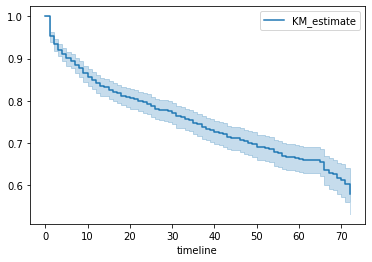

In [14]:
from mlrun import run_local, NewTask, mlconf

run = run_local(
    NewTask(**task_params),
    handler=train_model,
    inputs={"dataset"  : DATA_URL},
    artifact_path=os.path.join(mlconf.artifact_path, "churn"))

## a peek at a pickled kaplan-meier model

In [15]:
from cloudpickle import load
model = load(open(os.path.join(mlconf.artifact_path, "churn", "models/cox/km/model.pkl"), "rb"))
model

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1318 total observations, 960 right-censored observations>

In [16]:
model.predict([1,10,30,100,200])

1      0.952200
10     0.856350
30     0.771364
100    0.580393
200    0.580393
Name: KM_estimate, dtype: float64

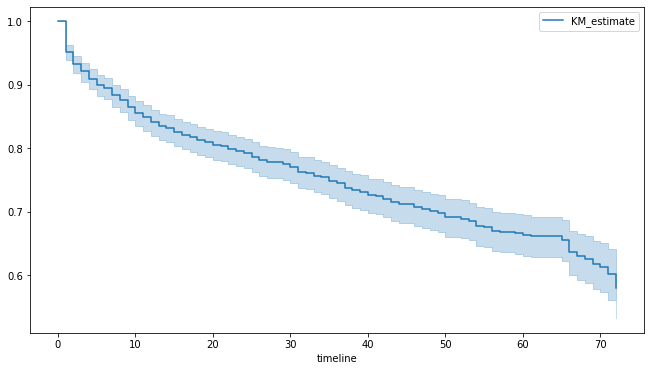

In [17]:
m = model.plot(figsize=(11,6))

## a peek at a pickeld cox hazards default model

In [18]:
from cloudpickle import load
model = load(open(os.path.join(mlconf.artifact_path, "churn", "models/cox/model.pkl"), "rb"))
model

<lifelines.CoxPHFitter: fitted with 1318 total observations, 960 right-censored observations>

In [19]:
model.print_summary()

### some potential default analyses of coxph

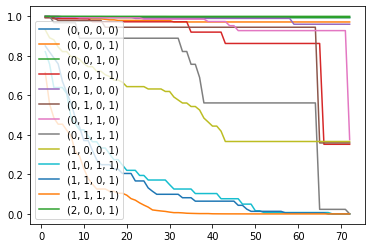

In [20]:
model.baseline_survival_.plot()

* run the following for each of the lines that passes some test (p < 0.005,for example):<br>
 `model.plot_covariate_groups('Contract_1', values=[0, 1]);`<br>
 the plot needs to have the strata decoded
 
 In the train_model above, set param `plot_cov_groups=True` and produce the following set of artifacts by selecting only those covariates whose p-values
 are below some threshold `p_value`

In [ ]:
# import matplotlib.pyplot as plt
# # need to add strata labels baseline legend
# ax = model.plot_covariate_groups('Contract_1', values=[0, 1])
# len(ax)